In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
path_to_zip_file = "../input/dogs-vs-cats/train.zip"
directory_to_extract_to = "./train"
import zipfile
with zipfile.ZipFile(path_to_zip_file,'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [3]:
path_to_zip_file = "../input/dogs-vs-cats/test1.zip"
directory_to_extract_to = "./test"
import zipfile
with zipfile.ZipFile(path_to_zip_file,'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

In [5]:
train_transform = transforms.Compose([ transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(0),
                                     transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

test_transform = transforms.Compose([transforms.RandomResizedCrop((224,224)),
                                     transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])


#data_dir = "../datasets/cat_vs_dog" # or the path where you have downloaded the dataset

train_data = datasets.ImageFolder('train', transform=train_transform)
test_data = datasets.ImageFolder( 'test', transform=test_transform)

In [6]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle = False)

In [7]:
# images,labels = next(iter(trainloader))
# images.size()

In [8]:
# plt.imshow(images.resize_(images.size()[2],125))

<AxesSubplot:>

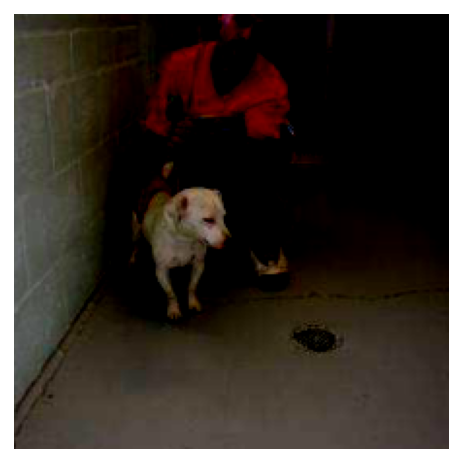

In [9]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


# Run this to test your data loaders
images, labels = next(iter(trainloader))
imshow(images[19], normalize=False)



In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16*53*53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


net = Net()


In [11]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epochs = 10
batch_size = 32
print_every = 30
for e in range(epochs):
    running_loss = 0
    total = 0
    correct = 0
    print(f"Epoch: {e+1}/{epochs}")
    
    net.train()
    for i,(images,labels) in enumerate(iter(trainloader)):
        optimizer.zero_grad()
        output = net.forward(images)    ##forward pass
        loss = criterion(output,labels) ##loss
        loss.backward()                 ##backward pass
        optimizer.step()                ##update model
        running_loss += loss.item()
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
        
    net.eval()
    with torch.no_grad():
        for i,(images,labels) in enumerate(iter(testloader)):
            outputs = net(images)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size()[0]
            correct += (predicted == labels).sum().item()
    print('Accuracy:',100*correct/total)
            
        

Epoch: 1/10


In [ ]:


import numpy as np
class_list = train_data.classes

def view_classify_general(img, ps, class_list):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    imshow(img, ax=ax1, normalize=True)
    ax1.axis('off')
    ax2.barh(np.arange(len(class_list)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(class_list)))
    ax2.set_yticklabels([x for x in class_list], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

images, labels = next(iter(trainloader))
img, label = images[0], labels[0]
# Flatten images
# Forward pass, get our logits
logits = net(img.view(1, *images[0].shape))
# Calculate the loss with the logits and the labels
ps = torch.exp(logits)
    
view_classify_general(img, ps, class_list)